<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/topology_representing_networks_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* sample 3d voxelized map, weighted by density, with low number of pseudo atoms
* using the topology representing networks approach

# Resources
* Zhang, Y., Krieger, J., Mikulska-Ruminska, K., Kaynak, B., Sorzano, C. O. S., Carazo, J. M., … Bahar, I. (2021). State-dependent sequential allostery exhibited by chaperonin TRiC/CCT revealed by network analysis of Cryo-EM maps.Progress in Biophysics and Molecular Biology, 160, 104–120. http://doi.org/10.1016/j.pbiomolbio.2020.08.006
  * and references therein. using for proteins goes back to 90s
* python code in prody 
  * http://prody.csb.pitt.edu/manual/reference/proteins/emdfile.html#TRNET
  * https://github.com/prody/ProDy/blob/697220825ebc7498d64f4e82f53bb7ff6d98027c/prody/proteins/emdfile.py#L466


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def doplt(arr): return(plt.imshow(arr,cmap='gray'))

In [2]:
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 51kB 3.5MB/s 


In [3]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/gauss_forward_model.py
!rm trn.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/343a9d4c49f6915e83e7895e2e1035e1da24edb3/src/trn.py
import trn, coords, gauss_forward_model


--2021-05-13 00:11:22--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   2.74K  --.-KB/s    in 0s      

2021-05-13 00:11:22 (59.9 MB/s) - ‘coords.py’ saved [2803/2803]

--2021-05-13 00:11:22--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/gauss_forward_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3047 (3.

<module 'trn' from '/content/trn.py'>

# EMDB data
* test out on real map

In [4]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-1961/map/emd_1961.map.gz

--2021-05-13 00:11:37--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-1961/map/emd_1961.map.gz
           => ‘emd_1961.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-1961/map ... done.
==> SIZE emd_1961.map.gz ... 10762066
==> PASV ... done.    ==> RETR emd_1961.map.gz ... done.
Length: 10762066 (10M) (unauthoritative)

emd_1961.map.gz     100%[===================>]  10.26M  36.7MB/s    in 0.3s    

2021-05-13 00:11:37 (36.7 MB/s) - ‘emd_1961.map.gz’ saved [10762066]



In [5]:
!gunzip emd_1961.map.gz

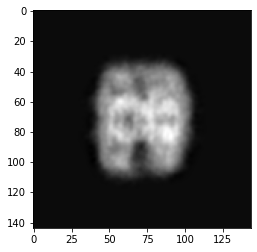

In [6]:
fname = 'emd_1961.map'
map_mrc = mrcfile.open(fname)
map_original = map_mrc.data
N = map_original.shape[0]
psize_original = map_mrc.voxel_size.item(0)[0]
psize = psize_original
doplt(map_original.sum(-1))

## thresholding map

It's important to first threshold by eye. Usually we'd do this in a molecular viewer and see at what level the "dust" started to appear

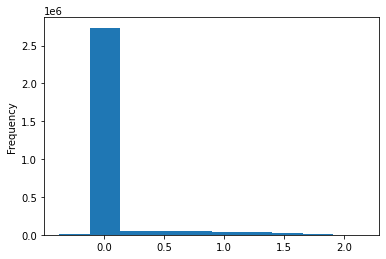

In [7]:
pd.Series(map_original.flatten()).plot.hist()

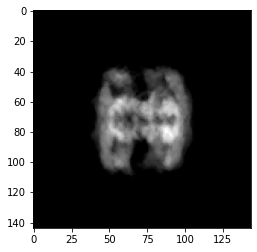

In [8]:
map_th = map_original.copy()
map_th[map_th < 1] = 0
doplt(map_th.sum(-1))

# TRN
* pick number of pseudo atoms
* dran initial pseudo atoms
* evolve pseudo atoms for `tf` time steps
* compare to (ground truth) initial density 

In [13]:
M=1000 # number of pseudo atoms
rm0,arr_flat,arr_idx,xyz,coords_1d = trn.trn_rm0(map_th,M,random_seed=None)

In [14]:
%%time
l0 = 0.005*M # larger tightens things up (far apart areas too much to much, pulls together). smaller spreads things out
lf = 0.5
tf = M*8
e0 = 0.3
ef = 0.05

rms,rs,ts_save = trn.trn_iterate(rm0,arr_flat,arr_idx,xyz,n_save=10,e0=e0,ef=ef,l0=l0,lf=lf,tf=tf,do_log=True,log_n=10)

0
800
1600
2400
3200
4000
4800
5600
6400
7200
CPU times: user 1.68 s, sys: 14.3 ms, total: 1.7 s
Wall time: 1.72 s


Note that the number of steps here depends on the number of pseudo atoms. The results are highy dependent on l0. You can tune the params by changing l0 to make things more gentle or harsh (too fast and things collapse, too slow and they don't move around). Start with a large tf and then scale back and adjust the other params to maintain convergence (close enough final pseudo atoms that cover the ground truth density sufficiently well).

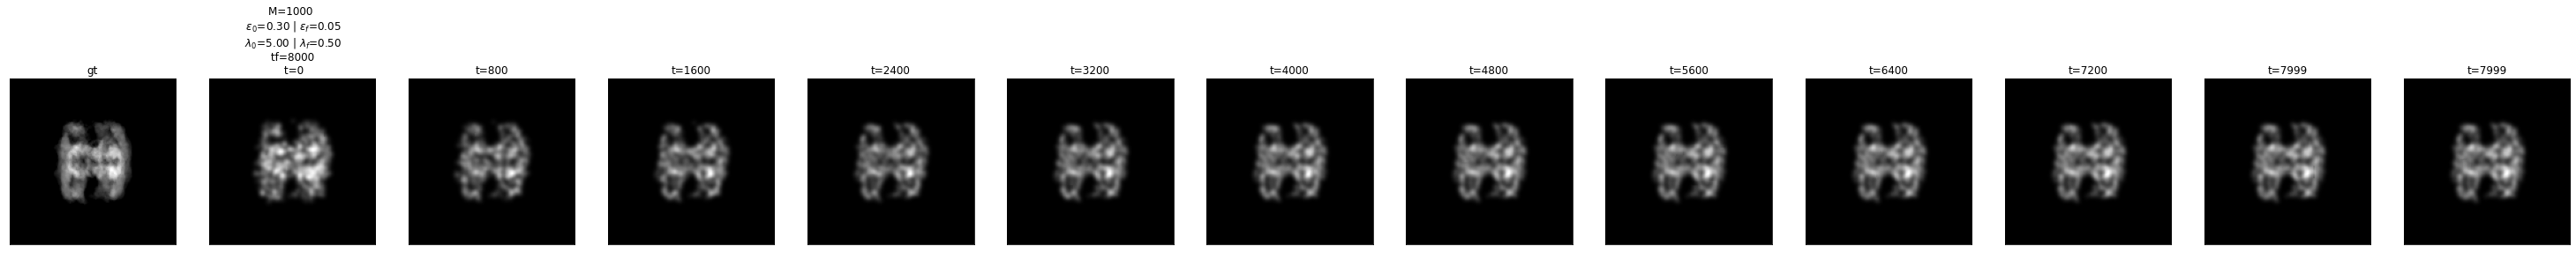

In [23]:
t_d={}
for save_idx,t in enumerate(ts_save):
  t_d[int(t)]=save_idx

xy = coords.coords_n_by_d(coords_1d,d=2)

sigma=2 # just changes visualizatoin (spread of a pseudo atom)
ts = [np.nan] + ts_save.tolist() + [tf-1] 

fig,axes = plt.subplots(ncols=len(ts),figsize=(4*len(ts),4))
for idx,t in enumerate(ts):
  if idx == 0:
    patoms_grid = map_th.sum(-1) #xyz
    axes[idx].set_title('gt')

  else:
    patoms_grid = gauss_forward_model.make_proj_mask(rms[t_d[int(t)]].T[[0,1]],xy[:,[1,0]],sigma=sigma,n_trunc=6*sigma,parallel_diff=True).T # for visualizing on graph. could also output xyz coordinates as pdb file and load in chimera
  if idx == 1:
    axes[idx].set_title('M=%i \n $\epsilon_0$=%.2f | $\epsilon_f$=%.2f \n $\lambda_0$=%.2f | $\lambda_f$=%.2f \n tf=%i \n t=%i'%(M,e0,ef,l0,lf,tf,t))
  elif idx > 1:
    axes[idx].set_title('t=%i'%t)

  axes[idx].imshow((patoms_grid),cmap='gray') 

  axes[idx].set_xticks([]) ; axes[idx].set_yticks([])

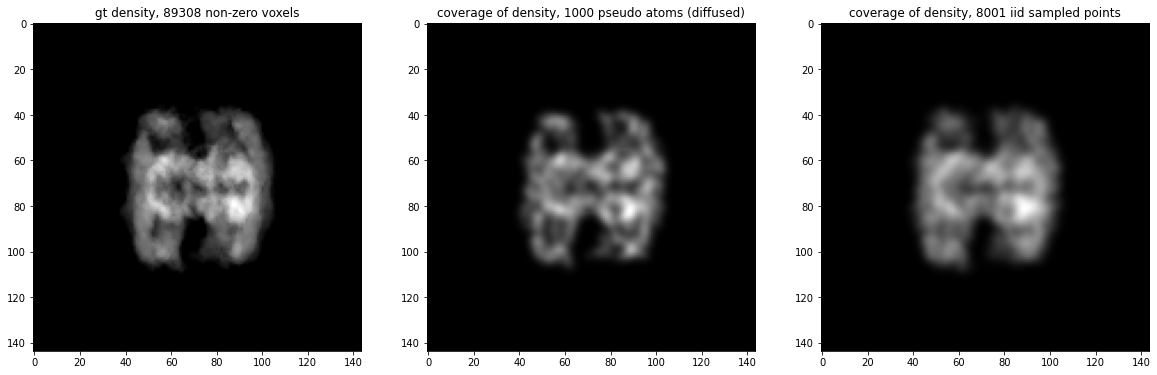

In [16]:
fig,axes = plt.subplots(ncols=3,figsize=(20,12)) ; idx=0
rms_grid = gauss_forward_model.make_proj_mask(rms[-1].T[[0,1]],xy[:,[1,0]],sigma=sigma,n_trunc=6*sigma,parallel_diff=True).T
axes[idx].imshow(map_th.sum(-1),cmap='gray') ; axes[idx].set_title('gt density, %i non-zero voxels' % (map_th > 0).sum()); idx+=1

rms_grid = gauss_forward_model.make_proj_mask(rms[-1].T[[0,1]],xy[:,[1,0]],sigma=sigma,n_trunc=6*sigma,parallel_diff=True).T
axes[idx].imshow(rms_grid,cmap='gray') ; axes[idx].set_title('coverage of density, %i pseudo atoms (diffused)' % rms.shape[1]); idx+=1

r_grid = gauss_forward_model.make_proj_mask(rs.T[[0,1]],xy[:,[1,0]],sigma=sigma,n_trunc=6*sigma,parallel_diff=True).T
axes[idx].imshow(r_grid,cmap='gray') ; axes[idx].set_title('coverage of density, %i iid sampled points' % rs.shape[0]); idx+=1